<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/fasttext_classification_ag_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package

In [1]:
# from IPython.display import clear_output
# ! git clone https://github.com/facebookresearch/fastText.git
# % cd ./fastText
# ! pip install .
# import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

Cloning into 'fastText'...
remote: Enumerating objects: 3840, done.
remote: Total 3840 (delta 0), reused 0 (delta 0), pack-reused 3840
Receiving objects: 100% (3840/3840), 8.21 MiB | 7.71 MiB/s, done.
Resolving deltas: 100% (2412/2412), done.
/content/fastText
Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3009241 sha256=b279349100540b7991488ef75831b1ede95ab6f6d18802d41b7c4fd61f343a66
  Stored in directory: /tmp/pip-ephem-wheel-cache-b7zfruzm/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data

True

In [18]:
df_test = pd.read_csv('/content/drive/My Drive/Data/Bert_ data augmentation-master/datasets/ag_news/train.csv')
df_dev = pd.read_csv('/content/drive/My Drive/Data/Bert_ data augmentation-master/datasets/ag_news/test.tsv', sep='\t')
print('test',len(df_test))
print('dev',df_dev.label.value_counts())


test 119999
dev 2    1900
1    1900
4    1900
3     380
Name: label, dtype: int64


In [2]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import itertools
import fasttext
import numpy as np

from sklearn.utils import resample
from tqdm import trange
from sklearn.metrics import precision_recall_fscore_support as score
import random
import shutil
import csv
import os
from sklearn.model_selection import train_test_split
import os.path as path
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

clear_output()

## Preprocessor

In [3]:
class Preprocessor():

  def __init__(self, path_, file_name, format_type, ratio):
    # abspath : the path of dataset
    
    self.path = path_
    self.file_name = file_name
    self.format_type = format_type
    self.ratio = ratio
    
  @staticmethod
  def normalizeString(s):
    s = s.str.lower()
    s = s.str.replace(r"<br />"," ")
    s = s.str.replace(r'(\W)(?=\1)', '')
    # s = s.str.replace(r"([.!?])", " \1")
    s = s.str.replace(r'\d', '')
    s = s.str.replace(r"[^a-zA-Z.!?]+", " ")
    s = s.str.replace(r"[\.\(\)\,\!\?\:\;\-\=]"," ")

    return s
  
  @staticmethod
  def load_data(path_, FILE_NAME, ratio, tech_name):
    
    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num = int(len(df_train) * ratio)
    df_train = df_train[ : num ]
    
    # num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())
    num_DA = len(df_train[df_train.label==0]) - len(df_train[df_train.label==2])

    if FILE_NAME == 'oversampling':
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==2], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    elif FILE_NAME == 'downsampling':
      df_down_samp = resample(df_train[df_train.label != 2], n_samples=len(df_train[df_train.label==2])*3, random_state=100, replace=True)
      df = pd.concat([df_down_samp, df_train[df_train.label == 2]])
    else:
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()
      if FILE_NAME == 'train' or tech_name == 'Back_trans':
        df = df[ : num ]

    if FILE_NAME not in ['train', 'dev', 'oversampling', 'test' , 'downsampling']:
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
        
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 
 
      df = pd.concat([df_train, df_over_samp]) 

    else: 
      pass

    df = df.sample(frac=1, replace=False, random_state=102)  
    print('value_counts', df.label.value_counts())
    return df
 
  def label_modify(self, data):
    
    data.sentence = self.normalizeString(data.sentence)
    data.label = data.label.apply(lambda x: '__label__' + str(x))
    return data

  def data_split(self):
    self.data = self.label_modify(self.data)

    df_dev = pd.read_csv(os.path.join(self.path, 'test.tsv'), sep='\t').dropna().reset_index()
    self.df_dev = self.label_modify(df_dev)
    

    if self.format_type=='tsv':
      self.data.to_csv(os.path.join(self.path, '{}.txt'.format(self.file_name)),
                                         sep='\t', index = False, header = False)
      self.df_dev.to_csv(os.path.join(self.path, 'test.txt'), sep='\t', index = False, header = False)
      
    else:
      self.data.to_csv(os.path.join(self.path, '{}.txt'.format(self.file_name)),
                                         sep='\t', index = False, header = False)
    
  def eval_matrix(self, label_list, pred_list):
    correct = sum([1 for i in range(len(label_list)) if pred_list[i]==label_list[i]])
    self.precision, self.recall, self.fscore, _ = score(label_list, pred_list) # 每个 class 单独的参数
    # the second score function is to get average score of evaluation matrix.
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred_list, average='macro' ) 
    acc = correct / len(label_list)
    return acc

  def train_and_test(self, tech_name):
    self.data  = self.load_data(self.path, self.file_name, self.ratio, tech_name)
    self.data_split()
    model = fasttext.train_supervised(os.path.join(self.path, 
                              '{}.txt'.format(self.file_name)), 
                              # dim=500, 
                              lr=0.2, 
                              # epoch=50, 
                              
                              # loss='hs'
                              )
    # print('model', model)
    pred_labels = []
    labels = self.df_dev.label.tolist()
    
    for i in range(len(self.df_dev)):
      pred_labels.append(model.predict(self.df_dev.loc[i].sentence)[0][0])
    
    acc = self.eval_matrix(labels, pred_labels)

    return model, acc, self.precision_avg, self.recall_avg, self.fscore_avg, self.precision, self.recall, self.fscore
    

### Until

In [4]:
class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(7,4)) 
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=10, color='gray', xytext=(10, 0), textcoords='offset points')
    
      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
    plt.show()
      # ax.set_ylabel("Methods")

  @staticmethod
  def path_setting(task_name, tech_name = 'Bert_ data augmentation-master'):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    return model_path, dataset_path, save_path

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(7, 4))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list):

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(5, 3))
      barWidth = 0.07
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['0', '1', '2'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


### Classification

In [5]:
# Fasttext clf to test Bert DA
class Clfier():

  def __init__(self, task_name, tech_name, ratio):
    self.task_name = task_name
    self.tech_name = tech_name
    self.ratio = ratio
    

  @staticmethod
  def path_setting(task_name, tech_name):
      abspath = '/content/drive/My Drive/Data/'
      model_path = path.join(abspath, tech_name + '/save_model')
      dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
      save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))

      return save_path

  def clf(self, file_name):

    save_path = self.path_setting(self.task_name, self.tech_name)
    if self.tech_name == 'Bert_ data augmentation-master' and self.task_name == 'rt-polaritydata':
      path_ = os.path.join(save_path, 'replacement')
    else:
      path_ = save_path

    df_train = pd.read_csv(os.path.join(path_, 'train.tsv'), sep='\t')
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    file_type = 'tsv'
      
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    
    preprocessor = Preprocessor(path_, file_name,  file_type, self.ratio)
    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = preprocessor.train_and_test(self.tech_name)

    print('              0          1          2         3')
    print('precision:', precision)
    print('recall:   ', recall)
    print('f1 score: ', fscore)
    print('-'*50)
    print("accuracy: %.4f%%" % (acc*100))
    print("precision: %.4f%%" % (precision_avg*100))
    print("recall: %.4f%%" % (recall_avg*100))
    print("f1 score: %.4f%%" % (fscore_avg*100))
      
    
    return model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore


### Execute

In [6]:

def Execute(test_list, task_name, tech_name, ratio):

  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []

  # model_path, dataset_path, save_path = path_setting(task_name, tech_name)
  clfer = Clfier(task_name, tech_name, ratio)

  for file_name in test_list:

    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = clfer.clf(file_name)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)

  utils.draw_final({
                    'accuracy': acc_list, 
                    'average precision': list_prec,
                    'average recall': list_recall,
                    'average fscore': list_fs, }, test_list)

  # utils.draw_other_final( {'precision': precision_list, 
  #                   'recall': recall_list, 'fscore': fscore_list}, test_list)


## Classifier

### *EDA* （test) 

start 2020-06-26 03:39:43.116010
ratio 0.2
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 3    5112
1    5083
0    5050
2    1075
Name: label, dtype: int64
              0          1          2         3
precision: [0.88387766 0.93825222 0.74294671 0.90265487]
recall:    [0.89736842 0.94368421 0.62368421 0.91263158]
f1 score:  [0.89057195 0.94096038 0.67811159 0.90761581]
--------------------------------------------------
accuracy: 89.9507%
precision: 86.6933%
recall: 84.4342%
f1 score: 85.4315%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 3    5112
1    5083
2    5050
0    5050
Name: label, dtype: int64
              0          1  

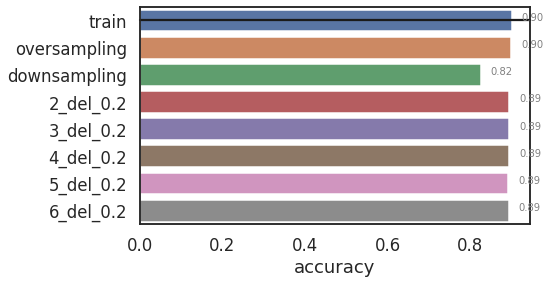

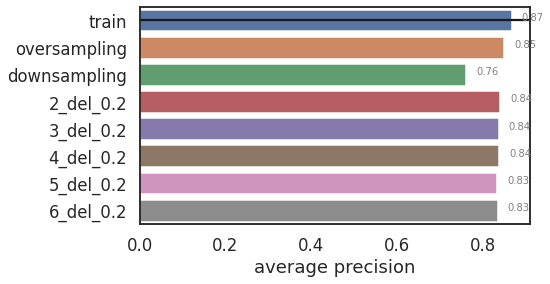

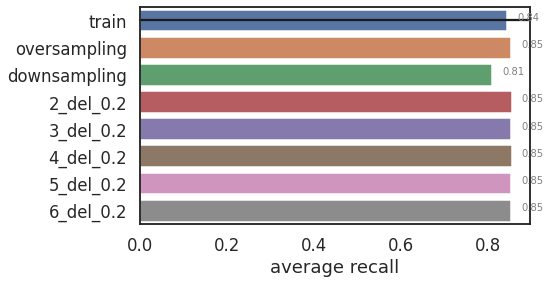

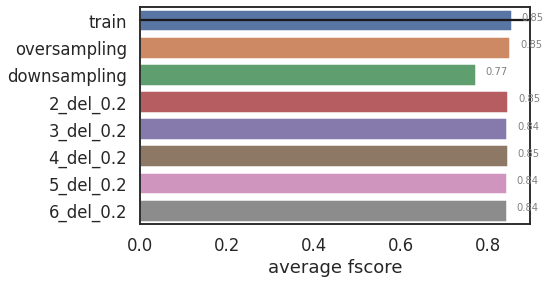

ratio 0.4
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 0    10213
1    10206
3    10167
2     2054
Name: label, dtype: int64
              0          1          2         3
precision: [0.90478695 0.94608605 0.76129032 0.90360825]
recall:    [0.90526316 0.96052632 0.62105263 0.92263158]
f1 score:  [0.90502499 0.9532515  0.68405797 0.91302083]
--------------------------------------------------
accuracy: 91.0197%
precision: 87.8943%
recall: 85.2368%
f1 score: 86.3839%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 2    10213
0    10213
1    10206
3    10167
Name: label, dtype: int64
              0          1          2         3
preci

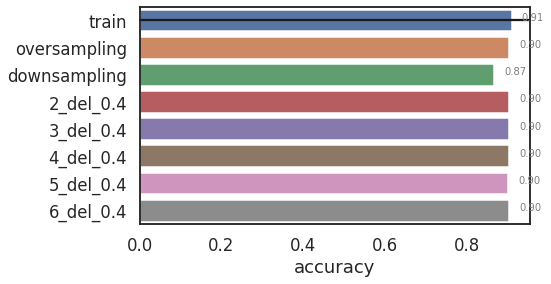

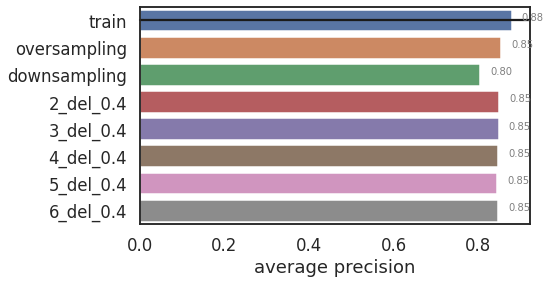

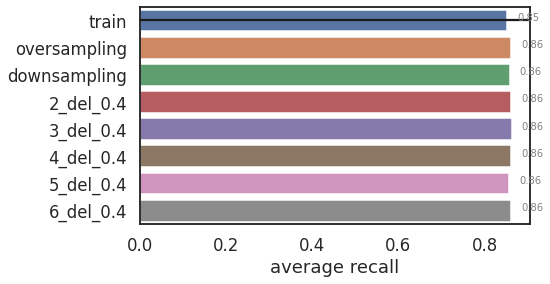

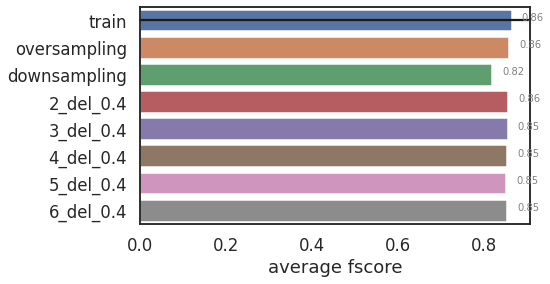

ratio 0.6
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    15413
3    15244
0    15228
2     3075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90057561 0.95036573 0.73394495 0.90404564]
recall:    [0.90578947 0.95736842 0.63157895 0.91736842]
f1 score:  [0.90317502 0.95385422 0.67892504 0.91065831]
--------------------------------------------------
accuracy: 90.8388%
precision: 87.2233%
recall: 85.3026%
f1 score: 86.1653%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    15413
3    15244
2    15228
0    15228
Name: label, dtype: int64
              0          1          2         3
preci

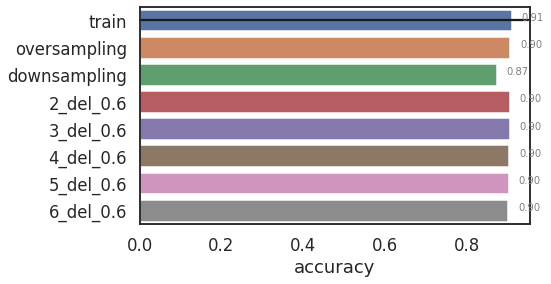

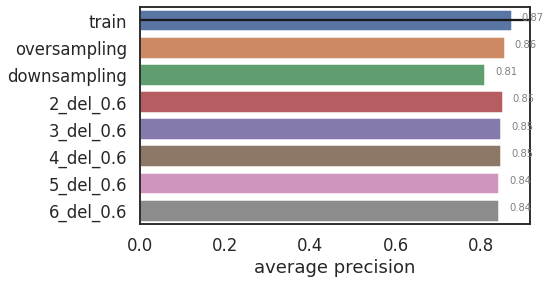

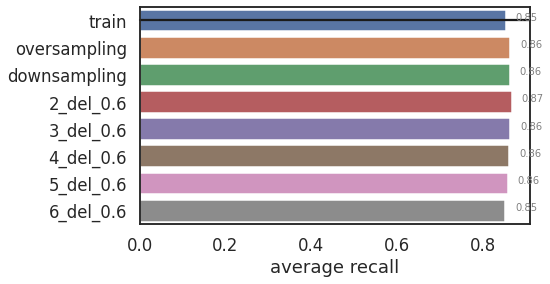

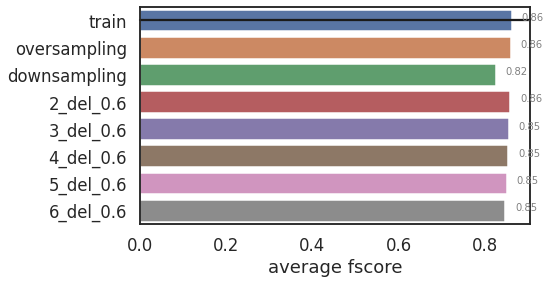

ratio 0.8
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    20522
3    20329
0    20322
2     4107
Name: label, dtype: int64
              0          1          2         3
precision: [0.90339426 0.95180723 0.74468085 0.91126103]
recall:    [0.91052632 0.95631579 0.64473684 0.92421053]
f1 score:  [0.90694626 0.95405618 0.69111425 0.9176901 ]
--------------------------------------------------
accuracy: 91.2500%
precision: 87.7786%
recall: 85.8947%
f1 score: 86.7452%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    20522
3    20329
2    20322
0    20322
Name: label, dtype: int64
              0          1          2         3
preci

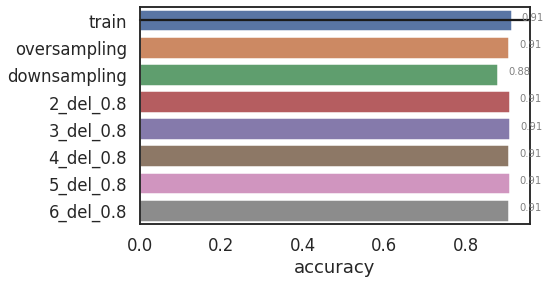

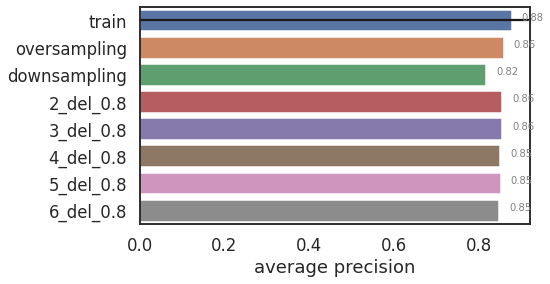

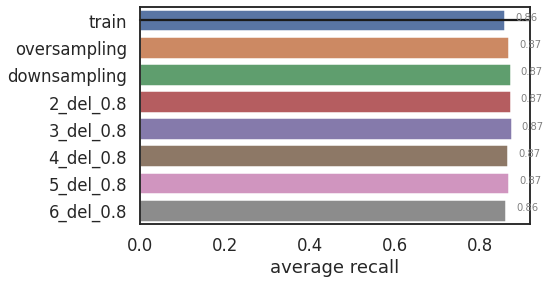

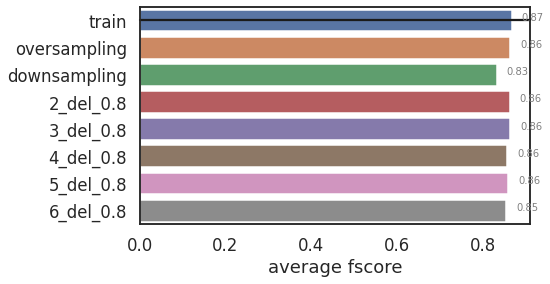

ratio 1
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    25523
0    25509
3    25493
2     5075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90995261 0.95075168 0.74251497 0.91710115]
recall:    [0.90947368 0.96526316 0.65263158 0.92578947]
f1 score:  [0.90971308 0.95795247 0.69467787 0.92142483]
--------------------------------------------------
accuracy: 91.5954%
precision: 88.0080%
recall: 86.3289%
f1 score: 87.0942%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    25523
2    25509
0    25509
3    25493
Name: label, dtype: int64
              0          1          2         3
precisi

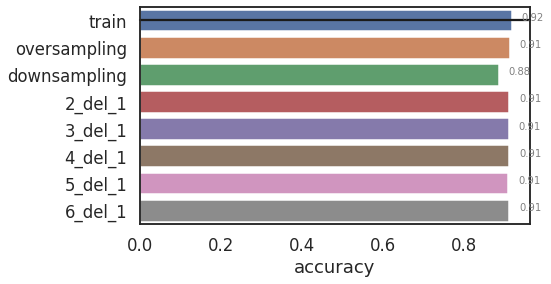

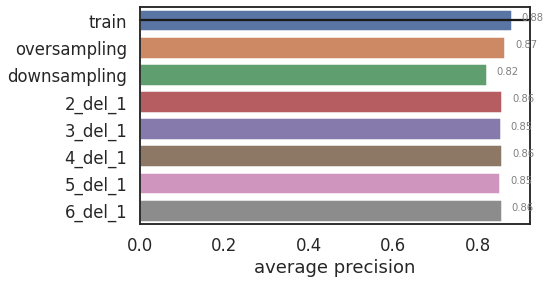

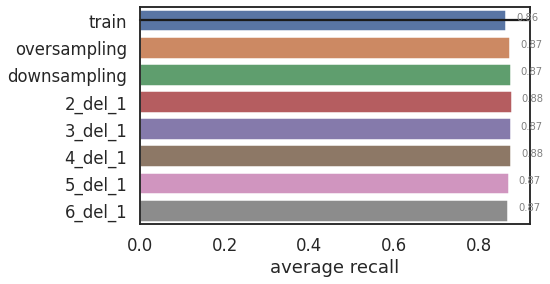

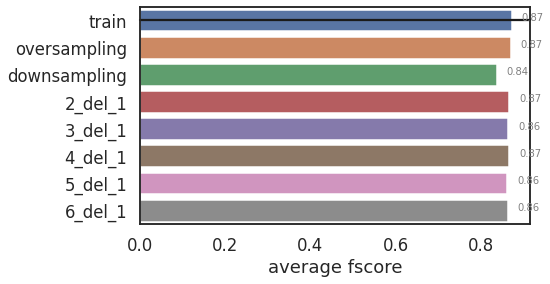

CPU times: user 4min 56s, sys: 4.7 s, total: 5min
Wall time: 5min 5s


In [40]:

%%time
starttime = datetime.datetime.now()
print('start', starttime)

      
task_name = 'ag_news'
tech_name = 'EDA'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('ratio', ratio)
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_del_0.2',
      '3_del_0.2',
      '4_del_0.2',
      '5_del_0.2',
      '6_del_0.2',
      ]
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_del_0.4',
      '3_del_0.4',
      '4_del_0.4',
      '5_del_0.4',
      '6_del_0.4',
      ]
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_del_0.6',
      '3_del_0.6',
      '4_del_0.6',
      '5_del_0.6',
      '6_del_0.6',
      ]
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_del_0.8',
      '3_del_0.8',
      '4_del_0.8',
      '5_del_0.8',
      '6_del_0.8',
      ]
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_del_1',
      '3_del_1',
      '4_del_1',
      '5_del_1',
      '6_del_1',
      ]

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT

### *Fasttext* （test)


start 2020-06-26 04:15:10.399741
ratio 0.2
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 3    5112
1    5083
0    5050
2    1075
Name: label, dtype: int64
              0          1          2         3
precision: [0.88387766 0.93825222 0.74294671 0.90265487]
recall:    [0.89736842 0.94368421 0.62368421 0.91263158]
f1 score:  [0.89057195 0.94096038 0.67811159 0.90761581]
--------------------------------------------------
accuracy: 89.9507%
precision: 86.6933%
recall: 84.4342%
f1 score: 85.4315%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 3    5112
1    5083
2    5050
0    5050
Name: label, dtype: int64
              0          1  

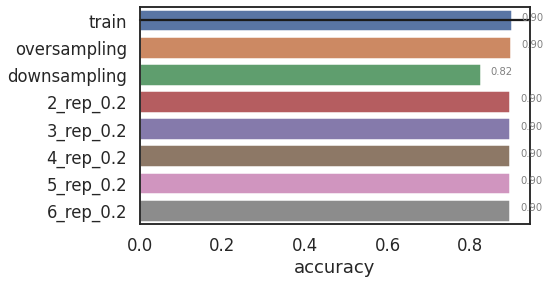

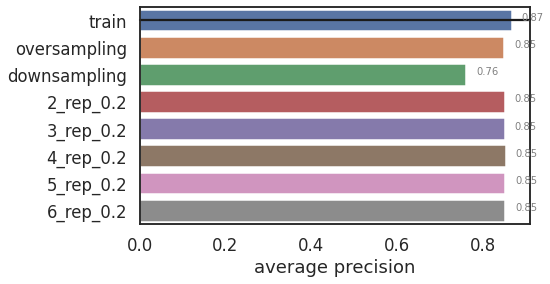

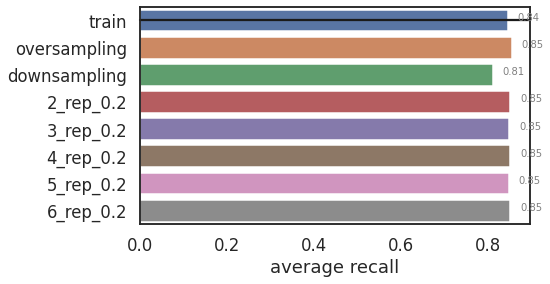

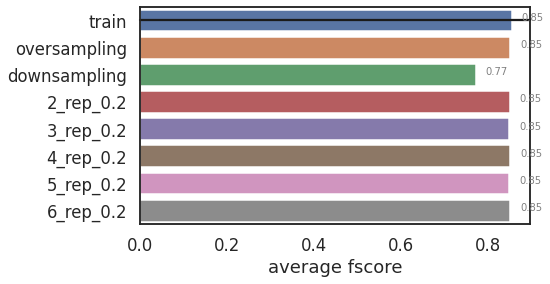

ratio 0.4
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 0    10213
1    10206
3    10167
2     2054
Name: label, dtype: int64
              0          1          2         3
precision: [0.90478695 0.94608605 0.76129032 0.90360825]
recall:    [0.90526316 0.96052632 0.62105263 0.92263158]
f1 score:  [0.90502499 0.9532515  0.68405797 0.91302083]
--------------------------------------------------
accuracy: 91.0197%
precision: 87.8943%
recall: 85.2368%
f1 score: 86.3839%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 2    10213
0    10213
1    10206
3    10167
Name: label, dtype: int64
              0          1          2         3
preci

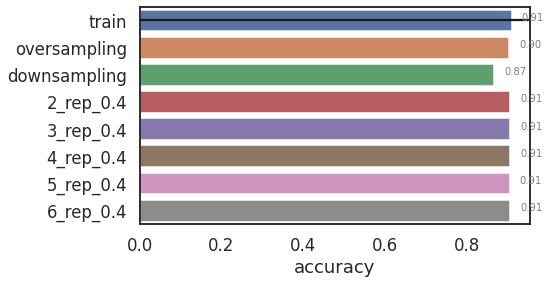

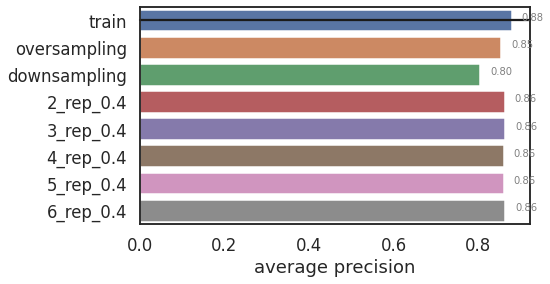

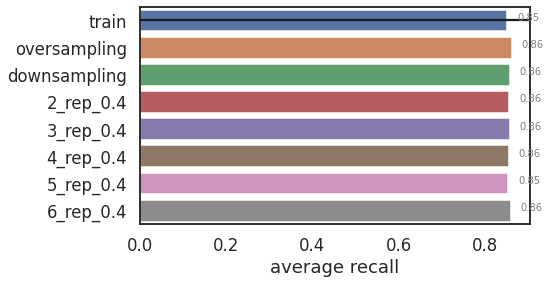

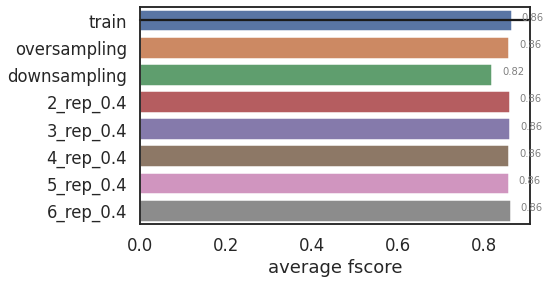

ratio 0.6
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    15413
3    15244
0    15228
2     3075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90057561 0.95036573 0.73394495 0.90404564]
recall:    [0.90578947 0.95736842 0.63157895 0.91736842]
f1 score:  [0.90317502 0.95385422 0.67892504 0.91065831]
--------------------------------------------------
accuracy: 90.8388%
precision: 87.2233%
recall: 85.3026%
f1 score: 86.1653%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    15413
3    15244
2    15228
0    15228
Name: label, dtype: int64
              0          1          2         3
preci

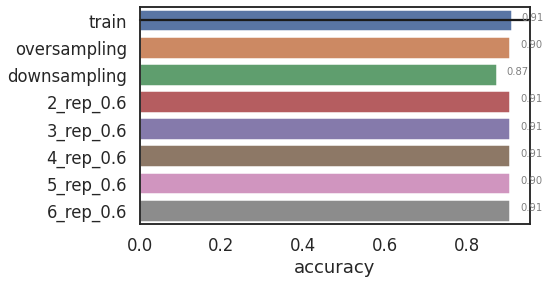

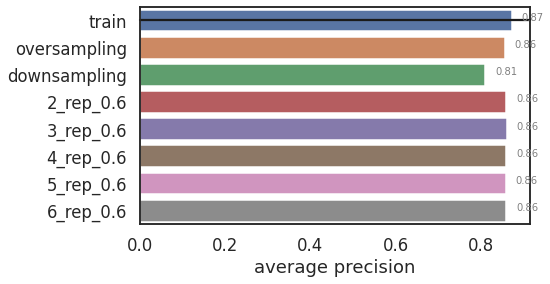

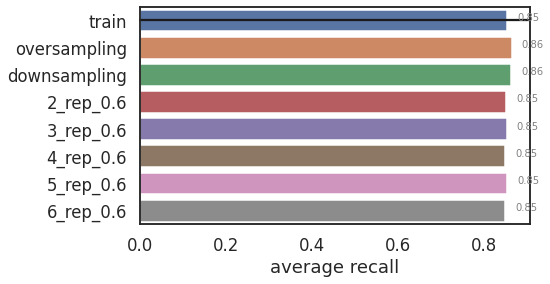

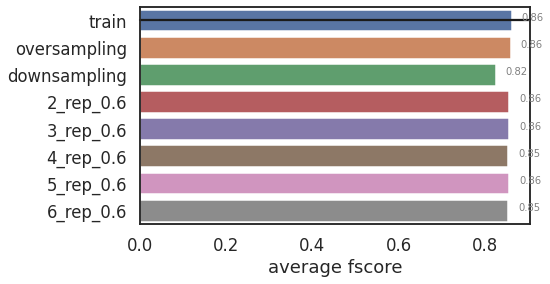

ratio 0.8
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    20522
3    20329
0    20322
2     4107
Name: label, dtype: int64
              0          1          2         3
precision: [0.90339426 0.95180723 0.74468085 0.91126103]
recall:    [0.91052632 0.95631579 0.64473684 0.92421053]
f1 score:  [0.90694626 0.95405618 0.69111425 0.9176901 ]
--------------------------------------------------
accuracy: 91.2500%
precision: 87.7786%
recall: 85.8947%
f1 score: 86.7452%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    20522
3    20329
2    20322
0    20322
Name: label, dtype: int64
              0          1          2         3
preci

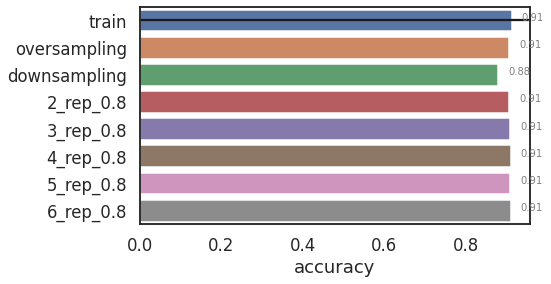

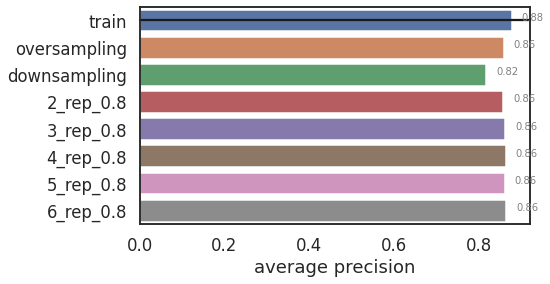

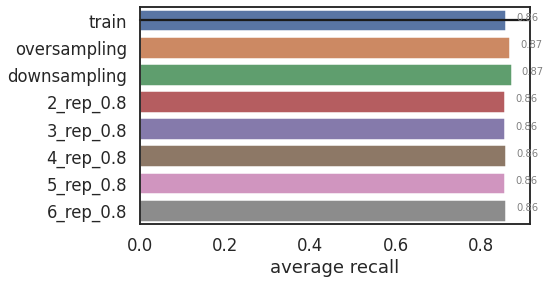

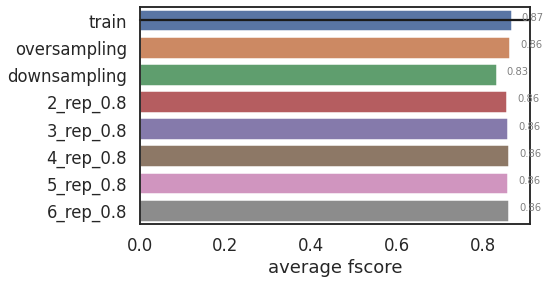

ratio 1
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    25523
0    25509
3    25493
2     5075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90995261 0.95075168 0.74251497 0.91710115]
recall:    [0.90947368 0.96526316 0.65263158 0.92578947]
f1 score:  [0.90971308 0.95795247 0.69467787 0.92142483]
--------------------------------------------------
accuracy: 91.5954%
precision: 88.0080%
recall: 86.3289%
f1 score: 87.0942%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    25523
2    25509
0    25509
3    25493
Name: label, dtype: int64
              0          1          2         3
precisi

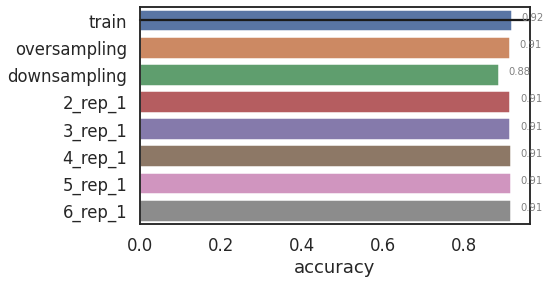

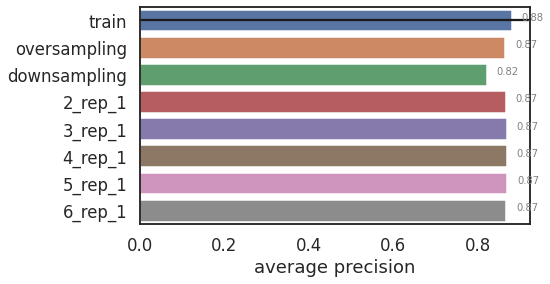

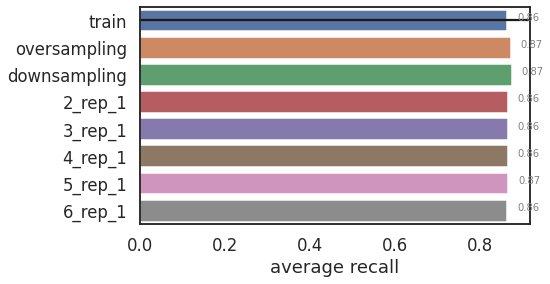

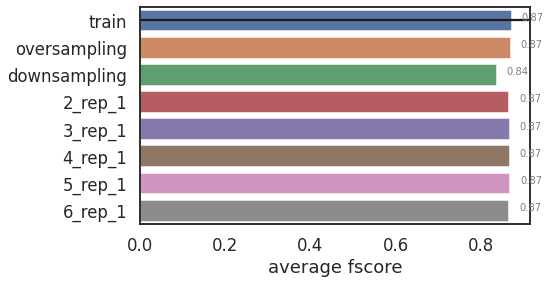

CPU times: user 4min 58s, sys: 4.65 s, total: 5min 3s
Wall time: 5min 55s


In [42]:
%%time
starttime = datetime.datetime.now()
print('start', starttime)
task_name = 'ag_news'
tech_name = 'Fasttext_augmentation'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('ratio', ratio)
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_0.2',
      '3_rep_0.2',
      '4_rep_0.2',
      '5_rep_0.2',
      '6_rep_0.2']
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_0.4',
      '3_rep_0.4',
      '4_rep_0.4',
      '5_rep_0.4',
      '6_rep_0.4']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_0.6',
      '3_rep_0.6',
      '4_rep_0.6',
      '5_rep_0.6',
      '6_rep_0.6']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_0.8',
      '3_rep_0.8',
      '4_rep_0.8',
      '5_rep_0.8',
      '6_rep_0.8']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
      '2_rep_1',
      '3_rep_1',
      '4_rep_1',
      '5_rep_1',
      '6_rep_1']

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT

### *Back_translation* (dev)

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.2
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 3    5112
1    5083
0    5050
2    1075
Name: label, dtype: int64
              0          1          2         3
precision: [0.88387766 0.93825222 0.74294671 0.90265487]
recall:    [0.89736842 0.94368421 0.62368421 0.91263158]
f1 score:  [0.89057195 0.94096038 0.67811159 0.90761581]
--------------------------------------------------
accuracy: 89.9507%
precision: 86.6933%
recall: 84.4342%
f1 score: 85.4315%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 3    5112
1    5083
2    5050
0    5050
Name: label, dtype: int64
              0          1          2         3
precision: [0

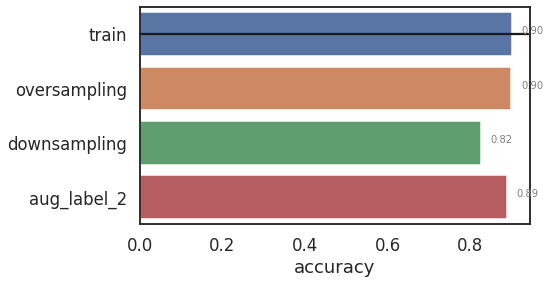

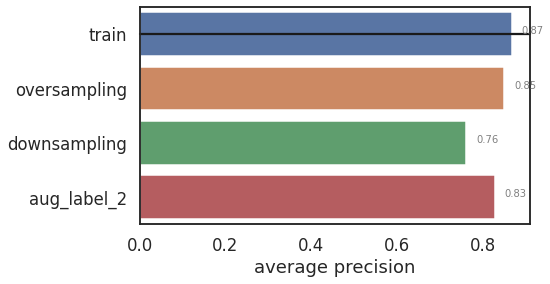

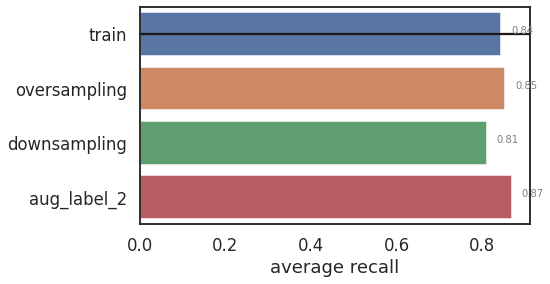

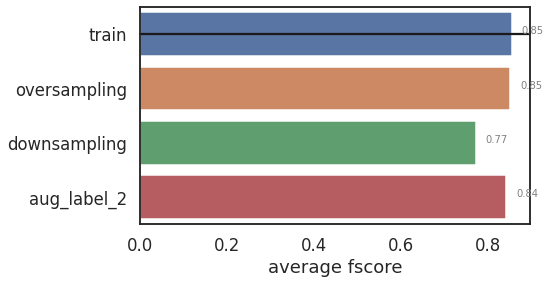

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.4
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 0    10213
1    10206
3    10167
2     2054
Name: label, dtype: int64
              0          1          2         3
precision: [0.90478695 0.94608605 0.76129032 0.90360825]
recall:    [0.90526316 0.96052632 0.62105263 0.92263158]
f1 score:  [0.90502499 0.9532515  0.68405797 0.91302083]
--------------------------------------------------
accuracy: 91.0197%
precision: 87.8943%
recall: 85.2368%
f1 score: 86.3839%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 2    10213
0    10213
1    10206
3    10167
Name: label, dtype: int64
              0          1          2         3
preci

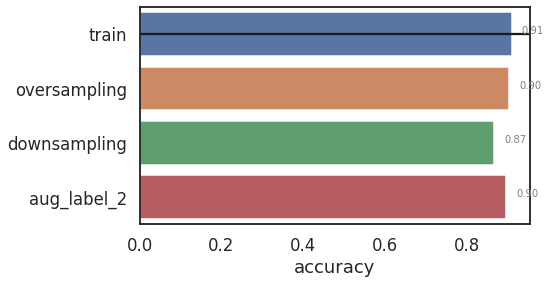

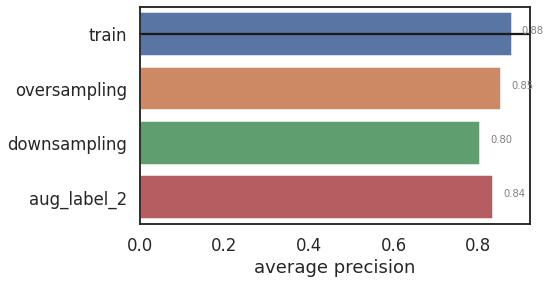

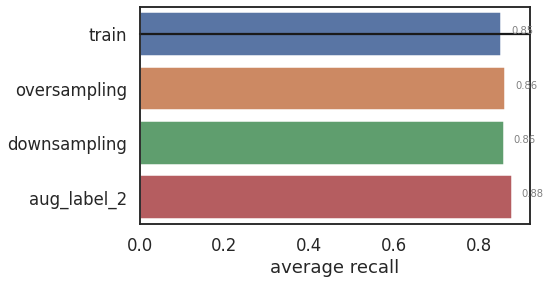

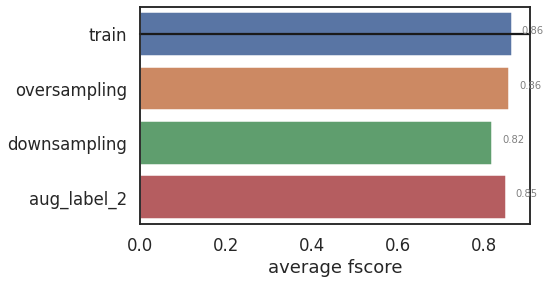

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.6
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    15413
3    15244
0    15228
2     3075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90057561 0.95036573 0.73394495 0.90404564]
recall:    [0.90578947 0.95736842 0.63157895 0.91736842]
f1 score:  [0.90317502 0.95385422 0.67892504 0.91065831]
--------------------------------------------------
accuracy: 90.8388%
precision: 87.2233%
recall: 85.3026%
f1 score: 86.1653%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    15413
3    15244
2    15228
0    15228
Name: label, dtype: int64
              0          1          2         3
preci

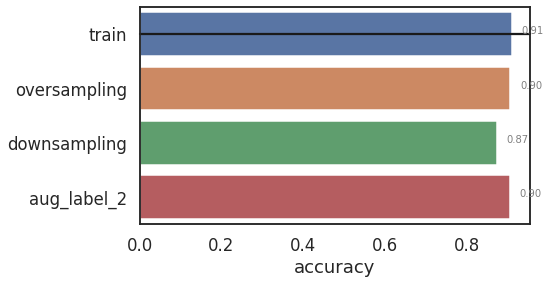

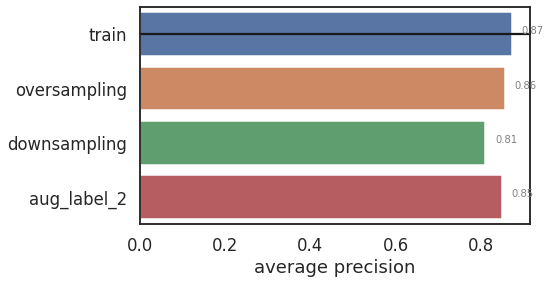

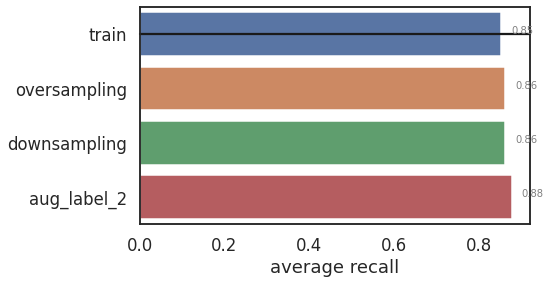

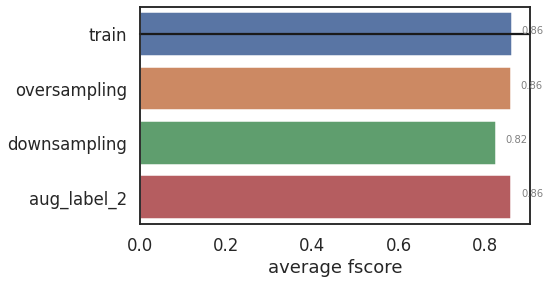

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 0.8
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    20522
3    20329
0    20322
2     4107
Name: label, dtype: int64
              0          1          2         3
precision: [0.90339426 0.95180723 0.74468085 0.91126103]
recall:    [0.91052632 0.95631579 0.64473684 0.92421053]
f1 score:  [0.90694626 0.95405618 0.69111425 0.9176901 ]
--------------------------------------------------
accuracy: 91.2500%
precision: 87.7786%
recall: 85.8947%
f1 score: 86.7452%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    20522
3    20329
2    20322
0    20322
Name: label, dtype: int64
              0          1          2         3
preci

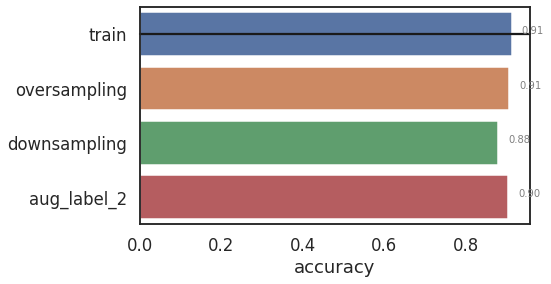

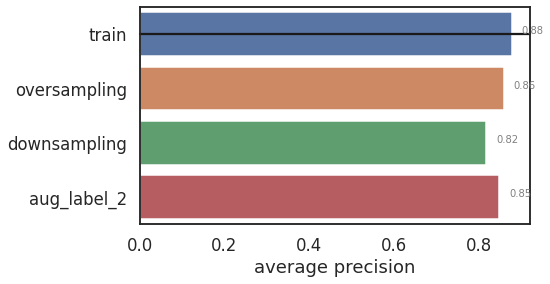

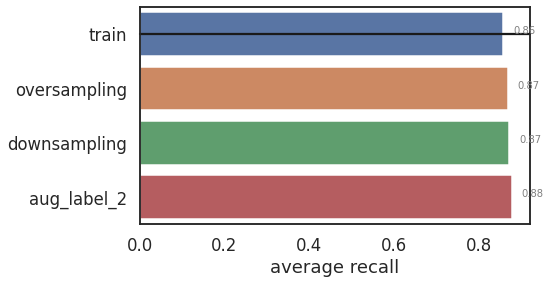

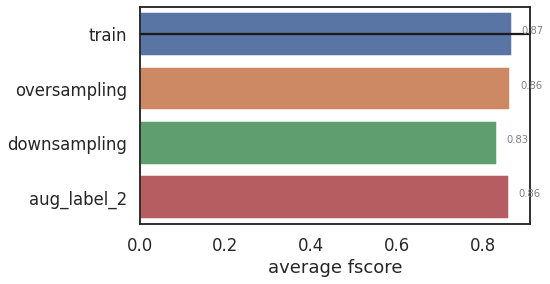

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ratio 1
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    25523
0    25509
3    25493
2     5075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90995261 0.95075168 0.74251497 0.91710115]
recall:    [0.90947368 0.96526316 0.65263158 0.92578947]
f1 score:  [0.90971308 0.95795247 0.69467787 0.92142483]
--------------------------------------------------
accuracy: 91.5954%
precision: 88.0080%
recall: 86.3289%
f1 score: 87.0942%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    25523
2    25509
0    25509
3    25493
Name: label, dtype: int64
              0          1          2         3
precisi

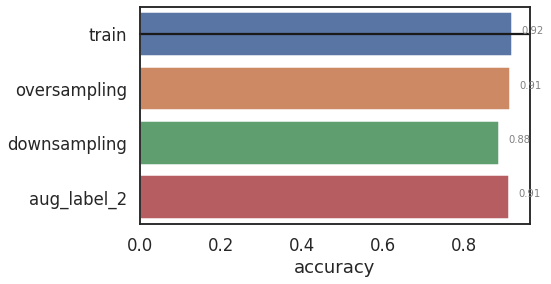

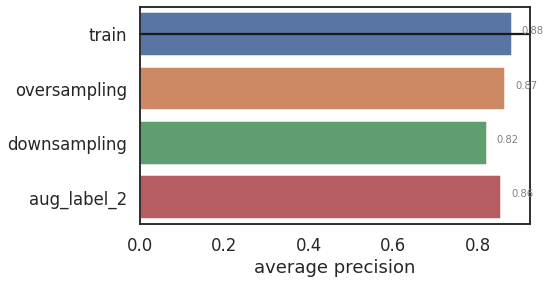

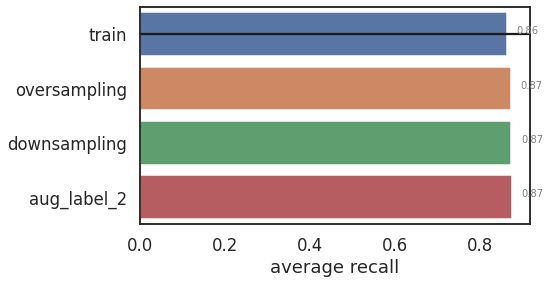

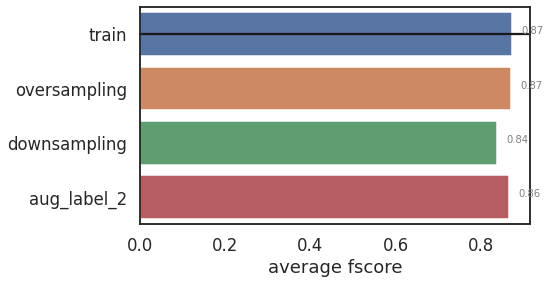

CPU times: user 2min 21s, sys: 2.74 s, total: 2min 24s
Wall time: 2min 29s


In [7]:
%%time
test_list = [
      'train',
      'oversampling',
      'downsampling',
      'aug_label_2',
      
      ]
      
task_name = 'ag_news'
tech_name = 'Back_trans'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('<'*50)
  print('ratio', ratio)
  Execute(test_list, task_name, tech_name, ratio)

### *Fine-tuned BERT* (test)

start 2020-06-26 04:21:09.628623
ratio 0.2
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 3    5112
1    5083
0    5050
2    1075
Name: label, dtype: int64
              0          1          2         3
precision: [0.88387766 0.93825222 0.74294671 0.90265487]
recall:    [0.89736842 0.94368421 0.62368421 0.91263158]
f1 score:  [0.89057195 0.94096038 0.67811159 0.90761581]
--------------------------------------------------
accuracy: 89.9507%
precision: 86.6933%
recall: 84.4342%
f1 score: 85.4315%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 3    5112
1    5083
2    5050
0    5050
Name: label, dtype: int64
              0          1  

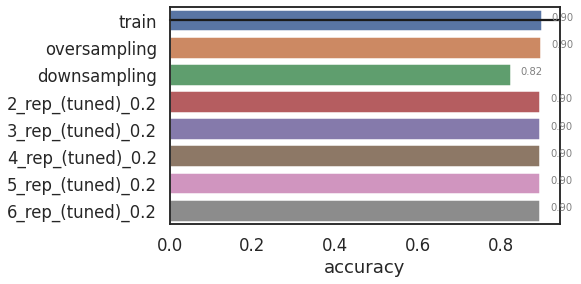

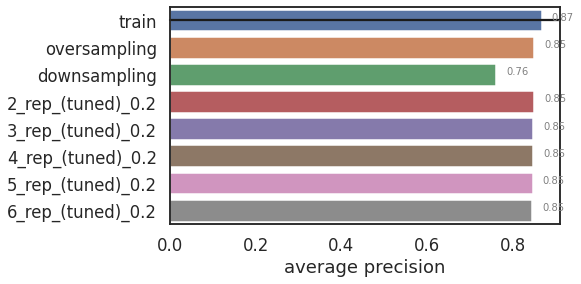

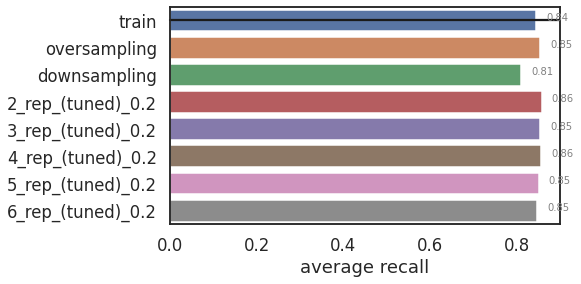

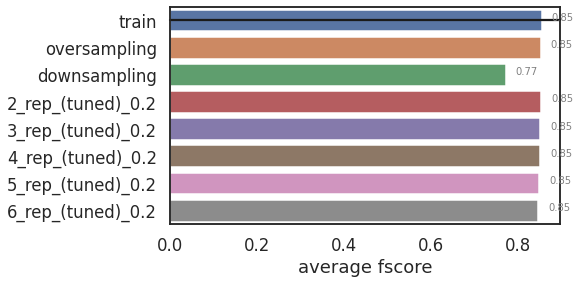

ratio 0.4
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 0    10213
1    10206
3    10167
2     2054
Name: label, dtype: int64
              0          1          2         3
precision: [0.90478695 0.94608605 0.76129032 0.90360825]
recall:    [0.90526316 0.96052632 0.62105263 0.92263158]
f1 score:  [0.90502499 0.9532515  0.68405797 0.91302083]
--------------------------------------------------
accuracy: 91.0197%
precision: 87.8943%
recall: 85.2368%
f1 score: 86.3839%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 2    10213
0    10213
1    10206
3    10167
Name: label, dtype: int64
              0          1          2         3
preci

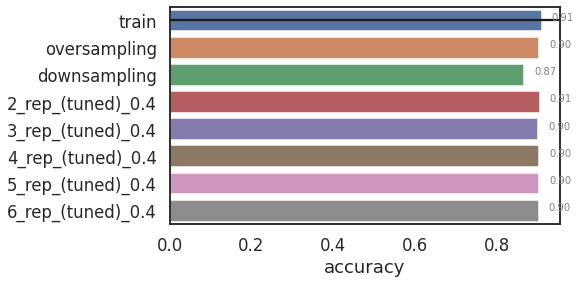

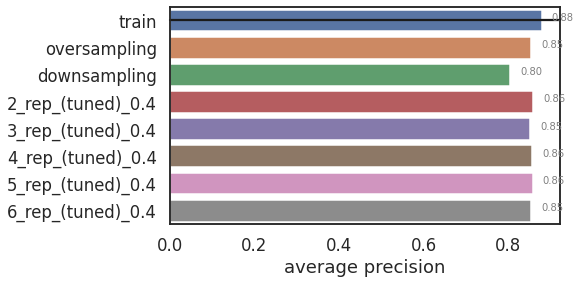

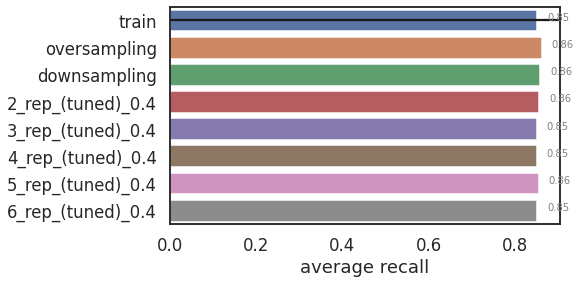

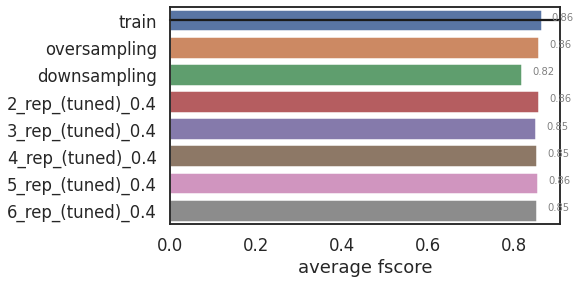

ratio 0.6
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    15413
3    15244
0    15228
2     3075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90057561 0.95036573 0.73394495 0.90404564]
recall:    [0.90578947 0.95736842 0.63157895 0.91736842]
f1 score:  [0.90317502 0.95385422 0.67892504 0.91065831]
--------------------------------------------------
accuracy: 90.8388%
precision: 87.2233%
recall: 85.3026%
f1 score: 86.1653%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    15413
3    15244
2    15228
0    15228
Name: label, dtype: int64
              0          1          2         3
preci

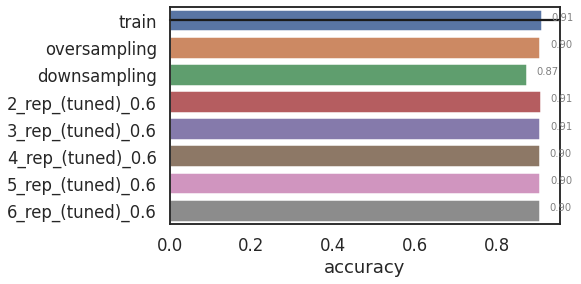

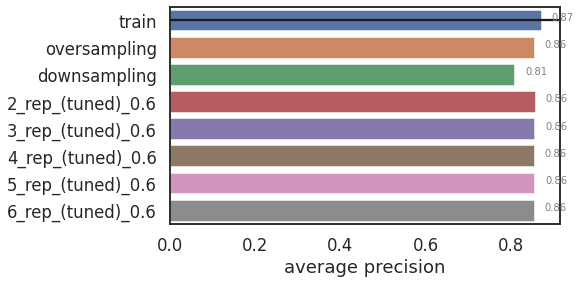

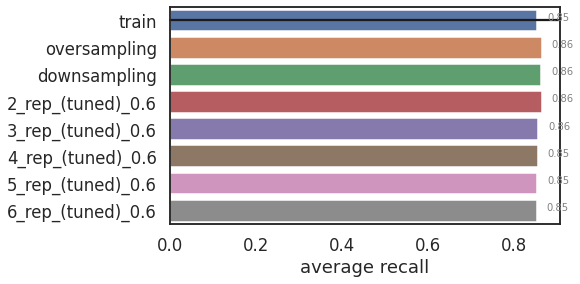

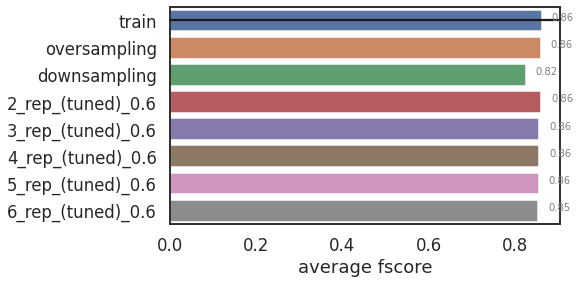

ratio 0.8
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    20522
3    20329
0    20322
2     4107
Name: label, dtype: int64
              0          1          2         3
precision: [0.90339426 0.95180723 0.74468085 0.91126103]
recall:    [0.91052632 0.95631579 0.64473684 0.92421053]
f1 score:  [0.90694626 0.95405618 0.69111425 0.9176901 ]
--------------------------------------------------
accuracy: 91.2500%
precision: 87.7786%
recall: 85.8947%
f1 score: 86.7452%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    20522
3    20329
2    20322
0    20322
Name: label, dtype: int64
              0          1          2         3
preci

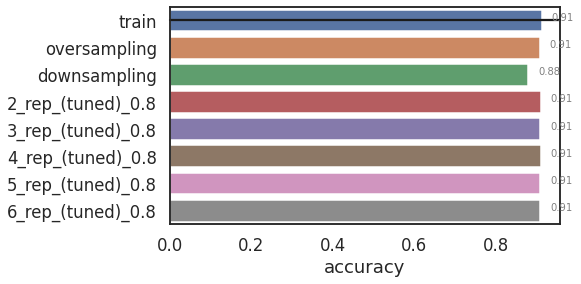

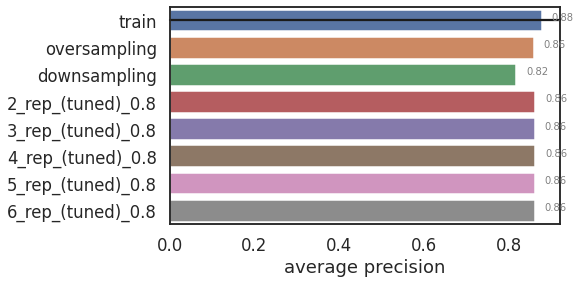

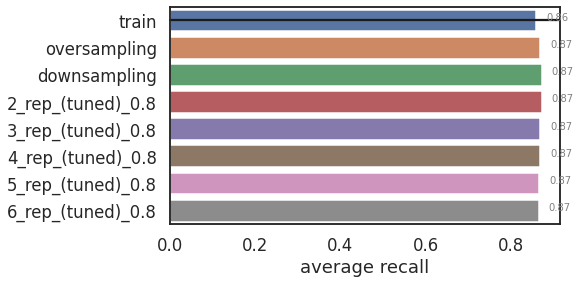

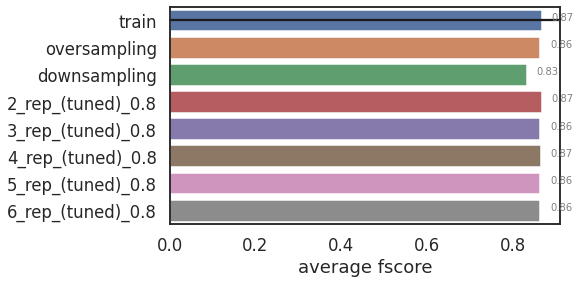

ratio 1
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    25523
0    25509
3    25493
2     5075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90995261 0.95075168 0.74251497 0.91710115]
recall:    [0.90947368 0.96526316 0.65263158 0.92578947]
f1 score:  [0.90971308 0.95795247 0.69467787 0.92142483]
--------------------------------------------------
accuracy: 91.5954%
precision: 88.0080%
recall: 86.3289%
f1 score: 87.0942%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    25523
2    25509
0    25509
3    25493
Name: label, dtype: int64
              0          1          2         3
precisi

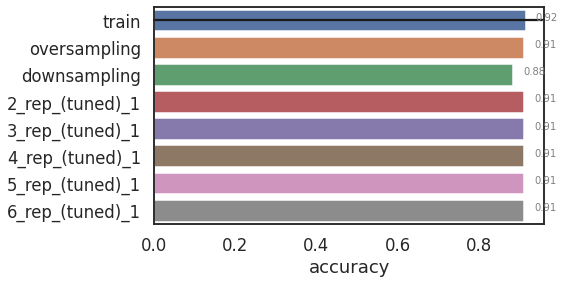

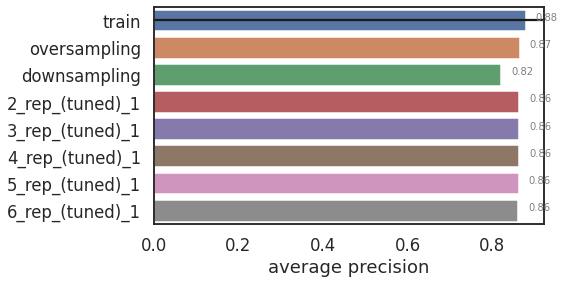

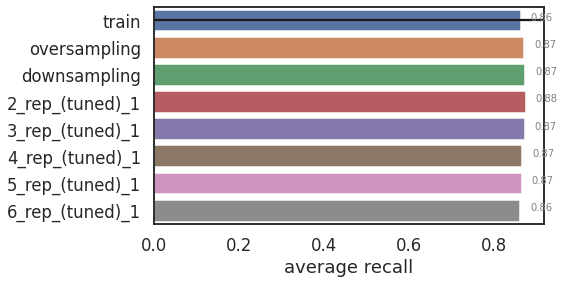

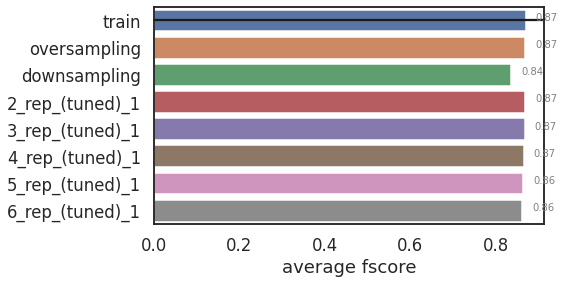

CPU times: user 4min 59s, sys: 4.54 s, total: 5min 4s
Wall time: 5min 28s


In [43]:
%%time
starttime = datetime.datetime.now()
print('start', starttime)
task_name = 'ag_news'
tech_name = 'Bert_ data augmentation-master'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('ratio', ratio)
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(tuned)_0.2',
      '3_rep_(tuned)_0.2',
      '4_rep_(tuned)_0.2',
      '5_rep_(tuned)_0.2',
      '6_rep_(tuned)_0.2']
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(tuned)_0.4',
      '3_rep_(tuned)_0.4',
      '4_rep_(tuned)_0.4',
      '5_rep_(tuned)_0.4',
      '6_rep_(tuned)_0.4']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(tuned)_0.6',
      '3_rep_(tuned)_0.6',
      '4_rep_(tuned)_0.6',
      '5_rep_(tuned)_0.6',
      '6_rep_(tuned)_0.6']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(tuned)_0.8',
      '3_rep_(tuned)_0.8',
      '4_rep_(tuned)_0.8',
      '5_rep_(tuned)_0.8',
      '6_rep_(tuned)_0.8']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(tuned)_1',
      '3_rep_(tuned)_1',
      '4_rep_(tuned)_1',
      '5_rep_(tuned)_1',
      '6_rep_(tuned)_1']

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT

### *Pretrain BERT* (test)

start 2020-06-26 04:26:38.538956
ratio 0.2
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 3    5112
1    5083
0    5050
2    1075
Name: label, dtype: int64
              0          1          2         3
precision: [0.88387766 0.93825222 0.74294671 0.90265487]
recall:    [0.89736842 0.94368421 0.62368421 0.91263158]
f1 score:  [0.89057195 0.94096038 0.67811159 0.90761581]
--------------------------------------------------
accuracy: 89.9507%
precision: 86.6933%
recall: 84.4342%
f1 score: 85.4315%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 3    5112
1    5083
2    5050
0    5050
Name: label, dtype: int64
              0          1  

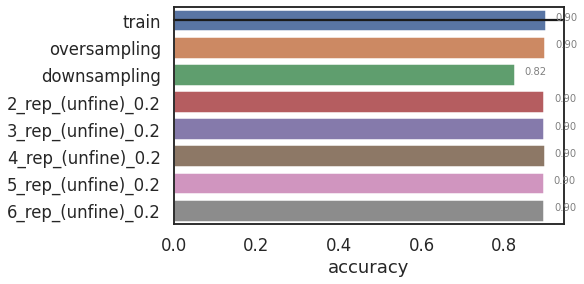

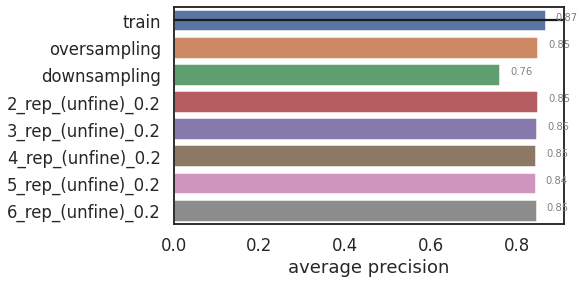

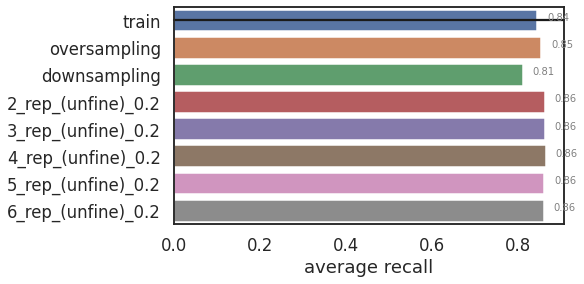

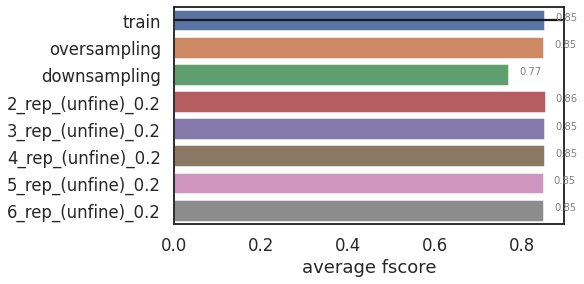

ratio 0.4
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 0    10213
1    10206
3    10167
2     2054
Name: label, dtype: int64
              0          1          2         3
precision: [0.90478695 0.94608605 0.76129032 0.90360825]
recall:    [0.90526316 0.96052632 0.62105263 0.92263158]
f1 score:  [0.90502499 0.9532515  0.68405797 0.91302083]
--------------------------------------------------
accuracy: 91.0197%
precision: 87.8943%
recall: 85.2368%
f1 score: 86.3839%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 2    10213
0    10213
1    10206
3    10167
Name: label, dtype: int64
              0          1          2         3
preci

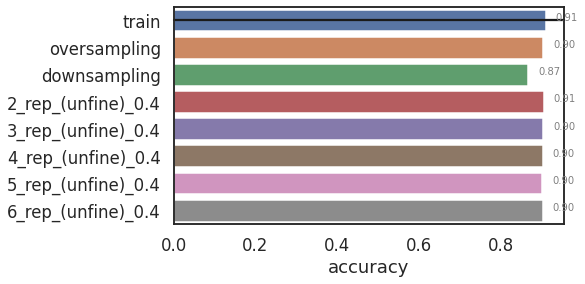

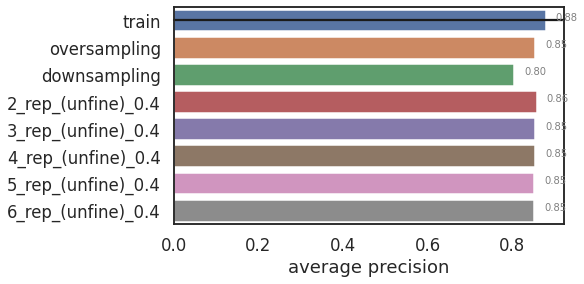

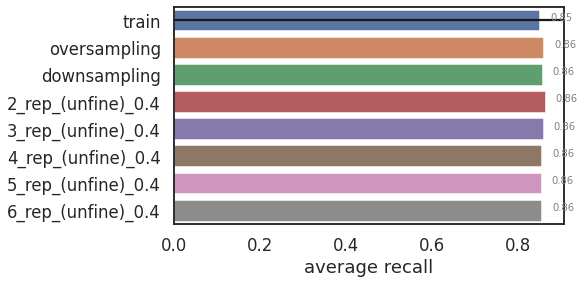

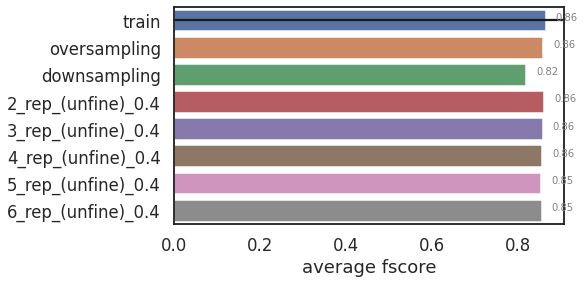

ratio 0.6
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    15413
3    15244
0    15228
2     3075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90057561 0.95036573 0.73394495 0.90404564]
recall:    [0.90578947 0.95736842 0.63157895 0.91736842]
f1 score:  [0.90317502 0.95385422 0.67892504 0.91065831]
--------------------------------------------------
accuracy: 90.8388%
precision: 87.2233%
recall: 85.3026%
f1 score: 86.1653%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    15413
3    15244
2    15228
0    15228
Name: label, dtype: int64
              0          1          2         3
preci

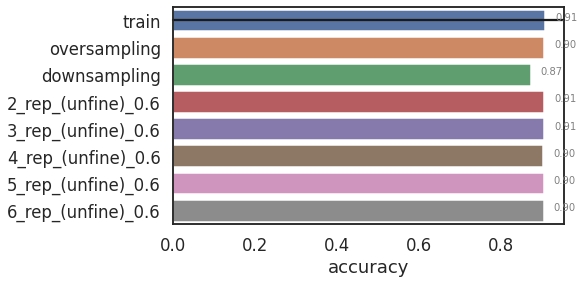

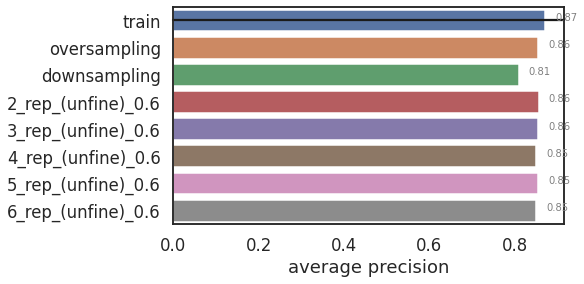

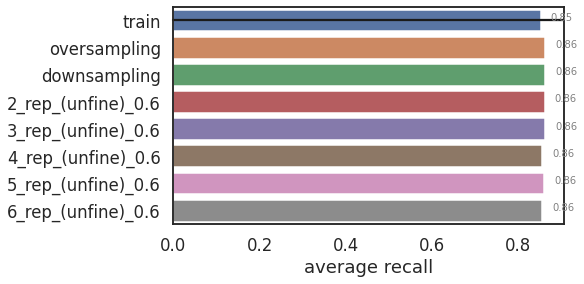

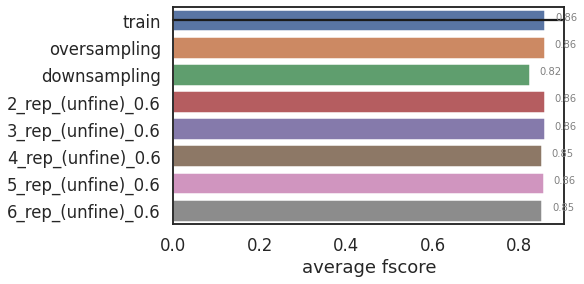

ratio 0.8
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    20522
3    20329
0    20322
2     4107
Name: label, dtype: int64
              0          1          2         3
precision: [0.90339426 0.95180723 0.74468085 0.91126103]
recall:    [0.91052632 0.95631579 0.64473684 0.92421053]
f1 score:  [0.90694626 0.95405618 0.69111425 0.9176901 ]
--------------------------------------------------
accuracy: 91.2500%
precision: 87.7786%
recall: 85.8947%
f1 score: 86.7452%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    20522
3    20329
2    20322
0    20322
Name: label, dtype: int64
              0          1          2         3
preci

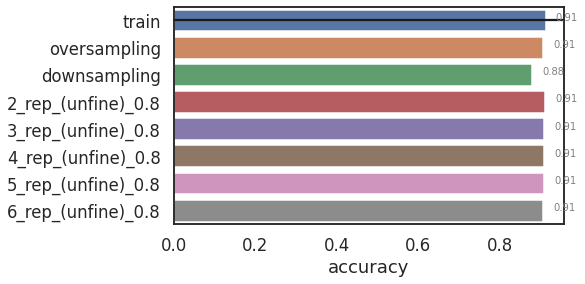

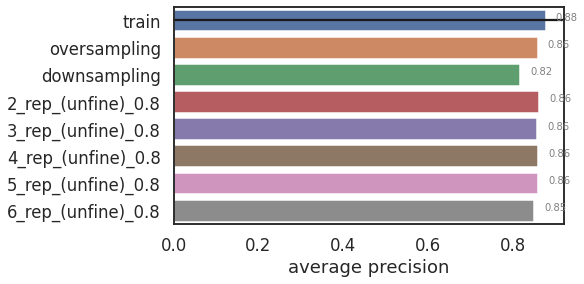

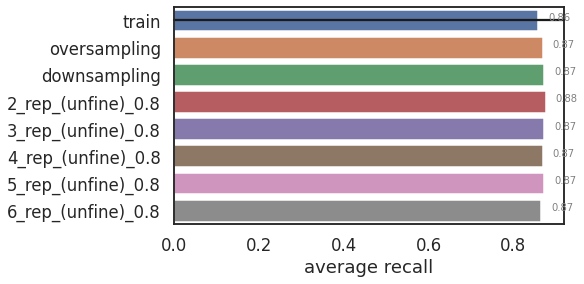

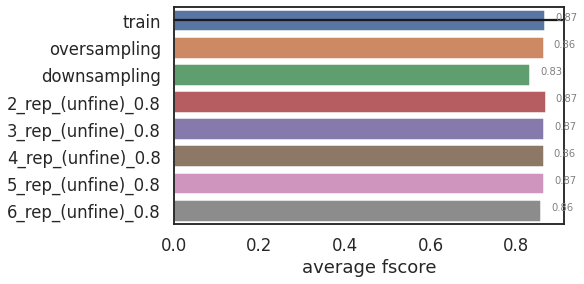

ratio 1
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
value_counts 1    25523
0    25509
3    25493
2     5075
Name: label, dtype: int64
              0          1          2         3
precision: [0.90995261 0.95075168 0.74251497 0.91710115]
recall:    [0.90947368 0.96526316 0.65263158 0.92578947]
f1 score:  [0.90971308 0.95795247 0.69467787 0.92142483]
--------------------------------------------------
accuracy: 91.5954%
precision: 88.0080%
recall: 86.3289%
f1 score: 87.0942%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
value_counts 1    25523
2    25509
0    25509
3    25493
Name: label, dtype: int64
              0          1          2         3
precisi

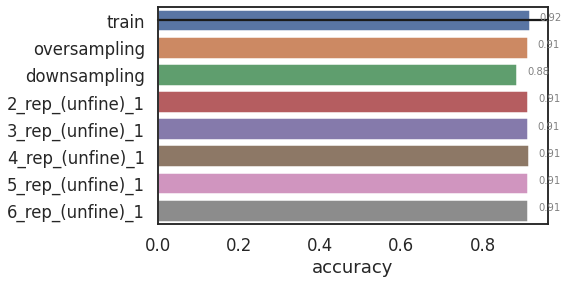

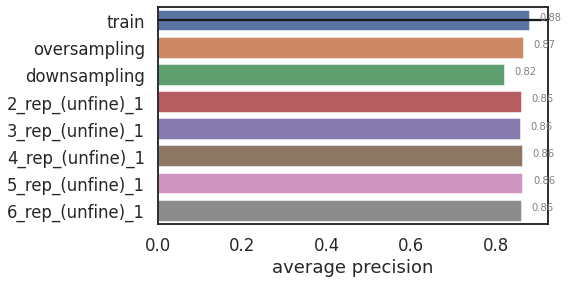

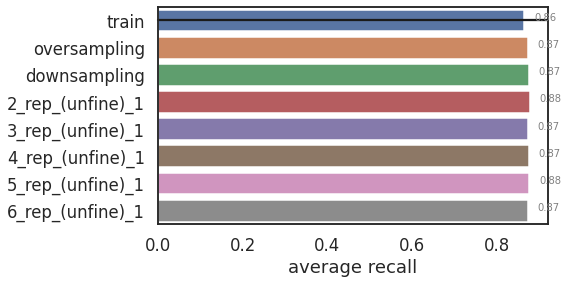

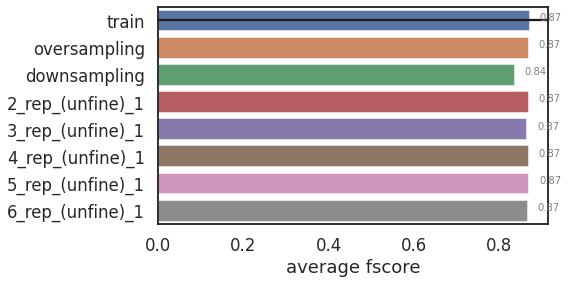

CPU times: user 4min 56s, sys: 4.7 s, total: 5min
Wall time: 5min 4s


In [44]:
%%time
starttime = datetime.datetime.now()
print('start', starttime)      
task_name = 'ag_news'
tech_name = 'Bert_ data augmentation-master'
ratios = [0.2, 0.4, 0.6, 0.8, 1]
for ratio in ratios:
  print('ratio', ratio)
  if ratio == 0.2:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(unfine)_0.2',
      '3_rep_(unfine)_0.2',
      '4_rep_(unfine)_0.2',
      '5_rep_(unfine)_0.2',
      '6_rep_(unfine)_0.2']
    print('<'*50)
    # print('ratio', ratio)
  if ratio == 0.4:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(unfine)_0.4',
      '3_rep_(unfine)_0.4',
      '4_rep_(unfine)_0.4',
      '5_rep_(unfine)_0.4',
      '6_rep_(unfine)_0.4']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.6:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(unfine)_0.6',
      '3_rep_(unfine)_0.6',
      '4_rep_(unfine)_0.6',
      '5_rep_(unfine)_0.6',
      '6_rep_(unfine)_0.6'] 
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 0.8:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(unfine)_0.8',
      '3_rep_(unfine)_0.8',
      '4_rep_(unfine)_0.8',
      '5_rep_(unfine)_0.8',
      '6_rep_(unfine)_0.8']
    print('<'*50)
    # print('ratio', ratio)

  if ratio == 1:
    test_list = ['train',
                 'oversampling',
                 'downsampling',
                 '2_rep_(unfine)_1',
      '3_rep_(unfine)_1',
      '4_rep_(unfine)_1',
      '5_rep_(unfine)_1', 
      '6_rep_(unfine)_1']

    print('<'*50)

  Execute(test_list, task_name, tech_name, ratio)

## Pretrain BERT

In [45]:
 l1 = [0.6365195866060515, 0.7182483700411779, 0.30462119235293017, 0.7146385108215694, 0.6797258553740138, 0.6918535784222948, 0.6487683560460218, 0.658037189668296]
 max(l1)

0.7182483700411779